## Difference-in-Differences (minimal) for time series
This notebook demonstrates a minimal DiD-style estimator using aggregated time series:

- treated series y
- control series control_series
- intervention date
  
We estimate the effect as the pre/post change in the treated-control difference, with block bootstrap CIs.

In [2]:
import sys
from pathlib import Path

repo_root = Path.cwd()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tecore.causal import DataSpec, ImpactConfig, ImpactMethod, run_impact

## 1) Build a small synthetic treated/control example

In [3]:
dates = pd.date_range("2025-01-01", periods=140, freq="D")
t = np.arange(len(dates))
control = 100 + 0.08 * t + 2.5 * np.sin(2 * np.pi * t / 7)
treated = control.copy()

intervention_date = "2025-04-01"
post = dates >= pd.Timestamp(intervention_date)
treated[post] += 3.5

df = pd.DataFrame({
    "date": dates.strftime("%Y-%m-%d"),
    "y": treated,
    "control_series": control,
})

df.head()

,date,y,control_series
0,2025-01-01,100.000000,100.000000
1,2025-01-02,102.034579,102.034579
2,2025-01-03,102.597320,102.597320
3,2025-01-04,101.324709,101.324709
4,2025-01-05,99.235291,99.235291


## 2) Run DiD

In [4]:
spec = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=["control_series"],
    freq="D",
)

cfg = ImpactConfig(
    intervention_date=intervention_date,
    method=ImpactMethod.DID,
    bootstrap_iters=200,
    block_size=7,
    alpha=0.05,
    run_placebo=True,
    n_placebos=25,
)

res = run_impact(df, spec, cfg)
res.summary()

{'method': 'did',
 'intervention_date': '2025-04-01',
 'point_effect': 3.5,
 'point_ci': (3.5, 3.5),
 'cum_effect': 175.0,
 'cum_ci': (157.4125, 175.0),
 'rel_effect': 0.032074513037778384,
 'rel_ci': (nan, nan),
 'p_value': None,
 'warnings': [],
 'diagnostics': {'mean_diff_pre': 0.0,
  'mean_diff_post': 3.5,
  'n_pre': 90,
  'n_post': 50},
 'economics': None}

### Plot treated vs counterfactual

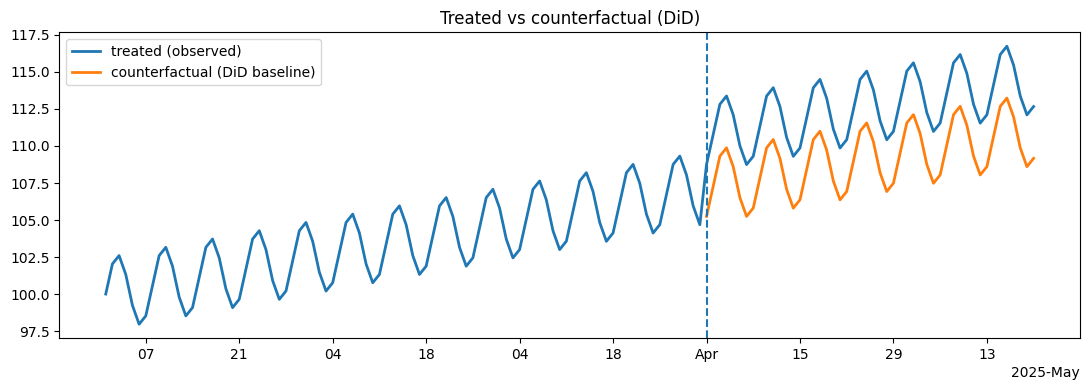

In [11]:
import matplotlib.dates as mdates

eff = res.effect_series.copy()
eff["date"] = pd.to_datetime(eff["date"])

plt.figure(figsize=(11, 4))
plt.plot(eff["date"], eff["y"], label="treated (observed)", linewidth=2)
plt.plot(eff["date"], eff["y_hat"], label="counterfactual (DiD baseline)", linewidth=2)
plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
plt.title("Treated vs counterfactual (DiD)")
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.tight_layout()
plt.show()

## 3) Save outputs

In [12]:
out_dir = repo_root / "out" / "notebook_11_did"
out_dir.mkdir(parents=True, exist_ok=True)

eff_out = out_dir / "effect_series.csv"
eff_to_save = res.effect_series.copy()
eff_to_save["date"] = pd.to_datetime(eff_to_save["date"]).dt.strftime("%Y-%m-%d")
eff_to_save.to_csv(eff_out, index=False)

import json
with open(out_dir / "summary.json", "w", encoding="utf-8") as f:
    json.dump(res.summary(), f, indent=2, ensure_ascii=False)

print("Wrote:", out_dir)

Wrote: /data/notebook_files/out/notebook_11_did


## Results summary

- We used **Difference-in-Differences (DiD)** to estimate the incremental impact of an intervention when we have a **treated** time series and a **control** time series that was not exposed to the change.
- The DiD counterfactual is constructed by projecting how the treated unit would have evolved **if it followed the control unit’s change** after the intervention date.
- The estimated impact is summarized as:
  - **Point effect (post-period)**: the level difference between observed treated `y` and the DiD counterfactual `y_hat`
  - **Cumulative effect**: sum of post-period point effects (useful for revenue/orders/margin interpretation)

### Interpretation

- DiD is credible when the **parallel trends assumption** is plausible: in the absence of treatment, treated and control would have evolved similarly.
- A quick practical check is the **pre-period behavior**: treated and control should have similar trend/seasonality patterns before the intervention, and the treated–counterfactual gap should be small and stable in the pre-period.

### What can go wrong

- If treated and control have different pre-trends (or a structural break in the control), DiD can produce biased estimates.
- Spillovers (control indirectly affected by the intervention) also invalidate the estimate.

### Next checks

- Visually inspect **treated vs control** in the pre-period (trend/seasonality similarity).
- Inspect **treated vs counterfactual (`y_hat`)**: pre-period matching and post-period gap stability.
- If you need uncertainty, add block bootstrap confidence intervals for the post-period effect.